## Overview of `pylabianca`
This notebook offers a relatively short overview of the `pylabianca` package.
It is not meant to be a comprehensive tutorial, but rather a quick overview of
some of the functionality.

In [2]:
import os
import os.path as op

import numpy as np

# temp for tests:
%load_ext autoreload
%autoreload 2

Set up paths to the data.

In [5]:
data_dir = r'C:\Users\Ola Kołodziej\Dropbox\Sarenka\PROJECTS\pylabianca\labianca_data\sub-U04_task-switchorder'
spike_data_dir = op.join(data_dir, 'sub-U04_ses-main_task-switchorder_run-01_sorter-osort_norm-False')

The files used here are only from Medial Temporal Lobe contacts, but still, including
waveforms the files take around 2 GB.

In [6]:
os.listdir(spike_data_dir)[:10]

['coincidence_per_pack.hdf5',
 'CSCA130_mm_format.mat',
 'CSCA132_mm_format.mat',
 'CSCA136_mm_format.mat',
 'CSCA139_mm_format.mat',
 'CSCA140_mm_format.mat',
 'CSCA145_mm_format.mat',
 'CSCA148_mm_format.mat',
 'CSCA150_mm_format.mat',
 'CSCA151_mm_format.mat']

We can read the whole directory of osort files using `pylabianca.io.read_osort`. This function can read data files saved either in the standard osort or "mm" formats. The data we use here have been curated and re-exported in the cleaner "mm" format, so we specify `format='mm'`. Aparat from spike data we will also read the waveforms for all the units. Note that reading waveforms is around 90% of reading time, so it slows down the reading to 5 - 10 seconds.

In [7]:
import pylabianca as pln

spk = pln.io.read_osort(spike_data_dir, waveform=True, format='mm')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.65it/s]


The `spk` variable we got is a `pylabianca.Spikes` object:

In [8]:
spk

<Spikes, 201 cells, 4078.6 spikes/cell on average>

This file contains a few duplicates (due to reference microelectrode and the fact that each microelectrode was sorted separately), so we will remove them. The duplicates were already detected previously and stored in a "drop_info" file. We will now read that file and remove the cells indicated by channel name x cluster id:

In [11]:
units_to_drop = pln.utils.read_drop_info(spike_data_dir + '_drop.txt')

In [13]:
units_to_drop[:4]

[('A140', 6068), ('A140', 6107), ('A140', 5766), ('A217', 4594)]

In [16]:
pln.utils.drop_cells_by_channel_and_cluster_id(spk, units_to_drop)

In [17]:
spk

<Spikes, 182 cells, 3906.1 spikes/cell on average>

From the text description above we see that now we have almost 20 cells less.

We will not discuss the internal structure of the `Spikes` object here, as we will mostly work on epoched data (and thus `SpikeEpochs` object will be used). But we'll plot a wavefrom density plot for first six units, just to show that it is simple (we use the `picks` argument to see specify which units we want to see):

array([[<Axes: title={'center': 'cell000'}, xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>,
        <Axes: title={'center': 'cell001'}, xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>,
        <Axes: title={'center': 'cell002'}, xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>],
       [<Axes: title={'center': 'cell003'}, xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>,
        <Axes: title={'center': 'cell004'}, xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>,
        <Axes: title={'center': 'cell005'}, xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>]],
      dtype=object)

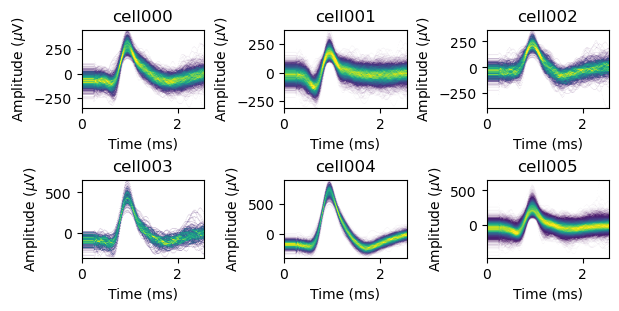

In [18]:
spk.plot_waveform(picks=[0, 1, 2, 3, 4, 5])

The data we use here may have some units that did not generate many spikes during the recording. So before moving further we will perform another simple cells selection. We will remove any units that have less than 250 spikes recorded. We can quickly check number of spikes per unit using `.n_spikes()` method:

In [19]:
min_spikes = 250
sel = spk.n_spikes() >= min_spikes

spk.pick_cells(sel)

<Spikes, 164 cells, 4319.3 spikes/cell on average>

From 182 units after duplicate removal we are now left with 164.  
Note that we used `.pick_cells()` to select units - a method that works in-place, so our original object is modified now (to work on a copy you can use `spk_sel = spk.copy().pick_cells(sel)`):

In [20]:
spk

<Spikes, 164 cells, 4319.3 spikes/cell on average>

### Reading events and epoching data

We now want to epoch the data with respect to image presentation. For this we will have to read the events from the raw NCS Events file.  
We use `read_events_neuralynx()` for this and ask for `format='mne'` to get a n_events x 3 array instead of a dataframe.

In [21]:
events = pln.io.read_events_neuralynx(data_dir, format='mne')

Let's take a look at how the events are represented:

In [22]:
events[:10]

array([[1645204607821876,                0,              255],
       [1645204624332275,                0,              150],
       [1645204973008229,                0,              151],
       [1645204973085448,                0,              100],
       [1645204974494885,                0,               13],
       [1645204976521134,                0,               22],
       [1645204978549383,                0,              102],
       [1645204983578381,                0,              232],
       [1645204986104599,                0,              240],
       [1645204997563063,                0,              242]],
      dtype=int64)

The events are read in mne-python compatible format: the first column is the timestamp, while the last one is the trigger value (the middle column is used by mne-python only in rare cases and is kept for compatibility).  
In the task used for this recording the participant is asked to remember two things: identity of an image and spatial position of a dot. We will look at image-evoked activity. Image presentation is represented by trigger values `110 + image_index`, so, because there are only three images here, the trigger values are: 110, 111, and 112.  
Additionally, because the task contains multiple parts (like training), we will filter out the events that are related only to the main part. We will do it by selecting only events before last `152` trigger (this trigger value informs about start of each experiment part).

In [12]:
event_id = [110, 111, 112]
last_part_start = np.where(events[:, -1] == 152)[0][-1]
use_events = events[:last_part_start]

We can now epoch spikes using `.epoch()` method of the `Spikes` object. We will epoch spikes with respect to image presentation, with 0.5 second pre-stimulus and 2 second post-stimulus window.

In [13]:
spk_epochs = spk.epoch(use_events, event_id, tmin=-0.5, tmax=2.)

Let's take a look at the text representation of the resulting `SpikeEpochs` object:

In [14]:
spk_epochs

<SpikeEpochs, 80 epochs, 175 cells, 108.4 spikes/cell on average>

### Computing and visualizing spike rate

Using `.spike_rate()` or `.spike_density()` methods we can compute spike rate or spike density for each unit and each epoch. Both methods return an xarray `DataArray`, which are very convenient for plotting as you will see.  
We will first compute spike rate with a moving window of `0.5` seconds long.

In [15]:
frate = spk_epochs.spike_rate(winlen=0.5)

Plotting `frate` object is easy, it has a `plot()` method and knows dimension names. Below we select fifth cell to plot - the one with index `4`):

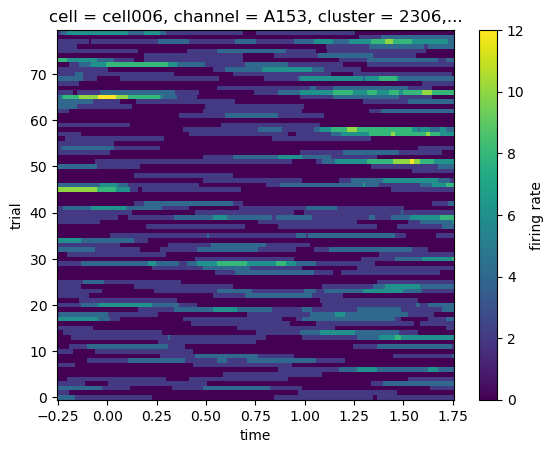

In [16]:
frate.isel(cell=4).plot()

To average the trial dimension we can use `.mean(dim='trial')`. Also note that below we select the cell of interest using `.isel()` method of `xarray.DataArray`:

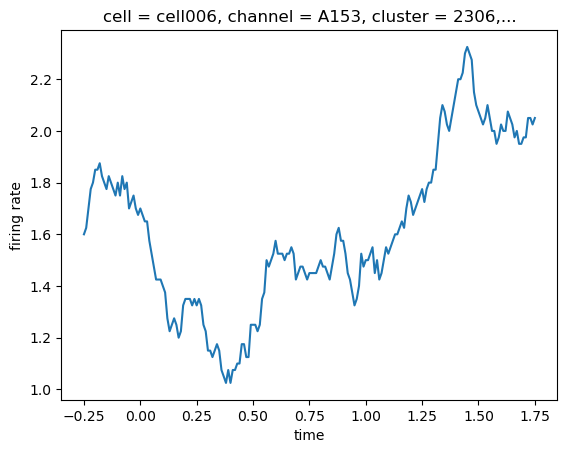

In [17]:
frate.isel(cell=4).mean(dim='trial').plot()

One disadvantage of native xarray plotting is that it is unable to plot error intervals. We can use `pylabianca.viz.plot_spike_rate` to plot the spike rate with standard error of the mean.

<Axes: title={'center': 'Firing rate'}, xlabel='Time (s)', ylabel='Spike rate (Hz)'>

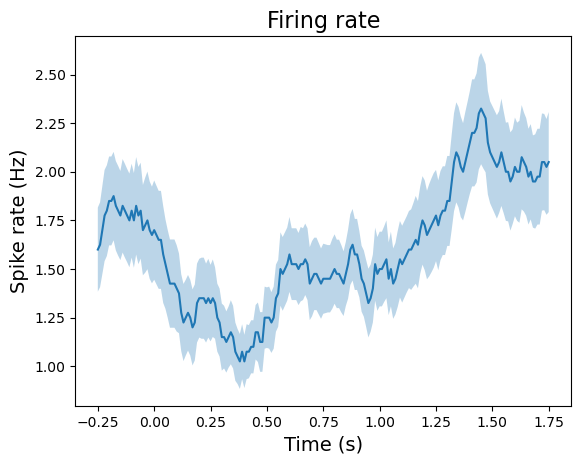

In [18]:
pln.viz.plot_spike_rate(frate.isel(cell=4))

Let's compare this to the spike density plot:

<Axes: title={'center': 'Firing rate'}, xlabel='Time (s)', ylabel='Spike rate (Hz)'>

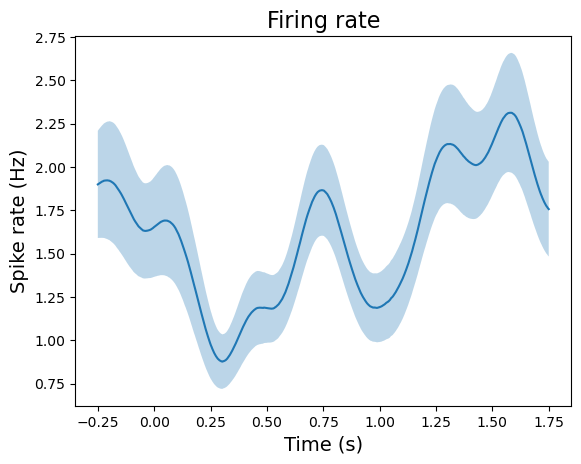

In [19]:
fdens = spk_epochs.spike_density(winlen=0.5, picks=4)
pln.viz.plot_spike_rate(fdens)

spike density has a different weighting profile than spike rate: by convolving the spikes with a gaussian, not a rectangular window, it gives a better time resolution trade-off and a smoother time course.  

To see the raster plot you can use `plot_raster()` function:

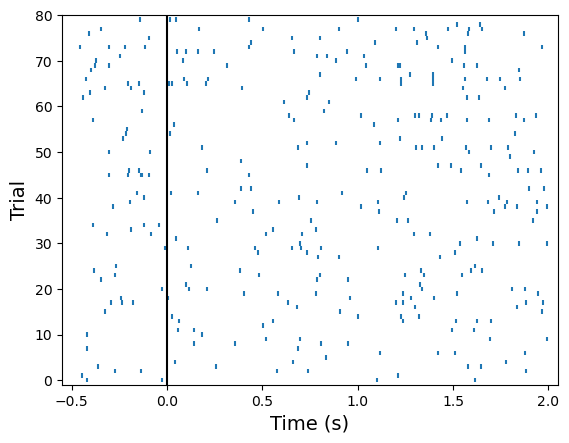

In [20]:
ax = pln.viz.plot_raster(spk_epochs, pick=4)

# we'll also add a vertical line at 0 seconds (image onset)
ax.axvline(x=0, color='k', lw=1.5)

To see both average spike rate and raseter plot in one figure, you can use `plot_spikes` function:

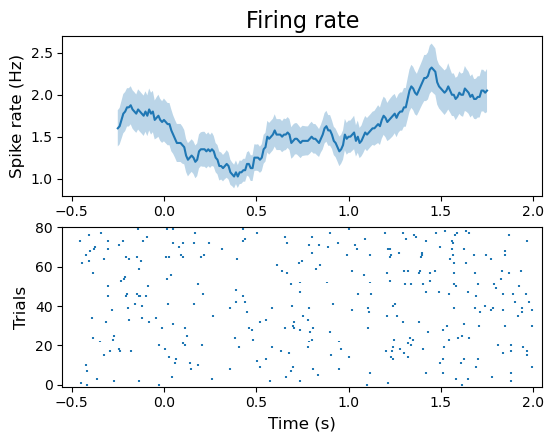

In [21]:
pln.viz.plot_spikes(spk_epochs, frate, pick=4);

Before we move on and introduce condition information, let's take a broad look a normalzied firing responses to image presentation for all cells. Again, because firing rate is an xarray, this is very easy to do: 

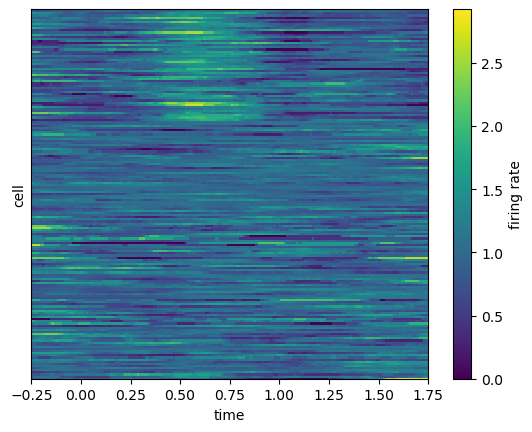

In [22]:
# calculate average across trials
frate_avg = frate.mean(dim='trial')

# normalize by each cell's time-average
frate_avg_norm = frate_avg / frate_avg.mean(dim='time')

# plot with cells on the y axis (the time will be on x axis then)
img = frate_avg_norm.plot(y='cell')

# the cell names printed on the y axis are not informative
# here, and would be to crowded to read anyway, so we remove them:
img.axes.set_yticks([]);

### Splitting by condition
However, to get the most out of xarray or pylabianca plotting it is good to have condition information in the `SpikeEpochs` object. We can add a dataframe of experimental information to `.metadata` attribute. We will construct the dataframe from trigger values here, but you can use a rich dataframe / log data output from your experiment.

In [23]:
import pandas as pd

# find only image presentation events
is_img = np.in1d(use_events[:, -1], event_id)

# subtract 110 to get image id
image = use_events[is_img, -1] - 110

# construct a dataframe
meta = pd.DataFrame({'image': image})

# show the first few rows
meta.head()

,image
0,1
1,2
2,1
3,0
4,2


Now we can set the metadata by placing the dataframe we constructed in the `.metadata` attribute:

In [24]:
spk_epochs.metadata = meta

Now, after recalculating firing rate again, the resulting xarray object will inherit `'image'` information, which can be used in plotting operations:

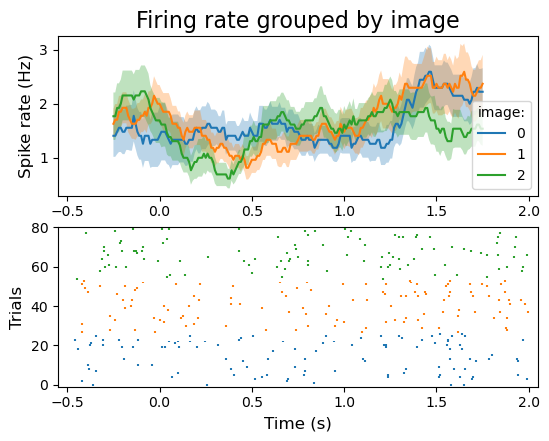

In [25]:
frate = spk_epochs.spike_rate(winlen=0.5)

pln.viz.plot_spikes(spk_epochs, frate, pick=4, groupby='image');

This cell does not seem to be image selective, but in the next section we will search for image selective cells using cluster based permutation test.

### Image selectivity
`pylabianca` allows for a few methods of detecting cells that differentiate between conditions. Some are geared towards assesing percentage of selectivity for specific structures, and some, more conservative approaches, aim to find cells with very clear selectivity profile. `pylabianca.selectivity.cluster_based_selectivity` is a member of this second group. Because it uses permutation test to assess significance, it may take some time - for this reason we set number of permutations only to `100` here. For serious analysis don't go below `1000` permutations though.

In [28]:
df_cluster = pln.selectivity.cluster_based_selectivity(
    frate, spk=spk_epochs, compare='image', n_permutations=100)

  0%|          | 0/175 [00:00<?, ?it/s]

C:\miniconda3\envs\mne2\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\miniconda3\envs\mne2\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\miniconda3\envs\mne2\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\miniconda3\envs\mne2\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\miniconda3\envs\mne2\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of t

We go some warnings, that you should not worry about. The main output `cluster_based_selectivity` is a dataframe with selectivity information. Let's take a look at the first few rows of this table:

In [29]:
df_cluster.head()

,neuron,region,region_short,anat,cluster,pval,window,preferred,n_preferred,FR_preferred,DoS,FR_vs_baseline
0,cell029,None,None,None,1,0.01,0.970 - 1.290,[1],1,0.347222,1.000000,0.868056
1,cell038,None,None,None,1,0.00,1.200 - 1.580,[1],1,0.877193,1.000000,5.847953
2,cell048,None,None,None,1,0.09,0.940 - 1.130,[1],1,2.144250,0.487762,2.042142
3,cell053,None,None,None,1,0.00,0.400 - 0.960,[1],1,1.719577,0.767751,2.865961
4,cell068,None,None,None,1,0.10,0.410 - 0.600,[1],1,0.389864,1.000000,1.417686


We can now assess the outcomes in this table with respect to cell being selective or not. We will use `pln.selectivity.assess_selectivity()` for this.  
We want a cluster p value < 0.05 (`min_cluster_p=0.05`), a cluster overlapping with window range 0.1 - 1 seconds post stimulus (`window_of_interest=(0.1, 1)`) at least in 0.2 seconds (`min_time_in_window=0.2`). Additionally we want the average firing rate in the cluster to at least 1.5 of the average baseline firing rate.

In [32]:
df_cluster = pln.selectivity.assess_selectivity(
    df_cluster, min_cluster_p=0.05, window_of_interest=(0.1, 1),
    min_time_in_window=0.2, min_FR_vs_baseline=1.5
)

Let's take a look how many selective cells we got, and what their properties look like.

In [37]:
df_cluster_sel = df_cluster.query('selective == True')
n_selective = df_cluster_sel.shape[0]
print(f'We got {n_selective} selective units.')
sel_names = df_cluster_sel.neuron.values
print(f'Selective cells: {sel_names}')

We got 2 selective units.
Selective cells: ['cell053' 'cell122']


In [35]:
df_cluster_sel

,neuron,region,region_short,anat,cluster,pval,window,preferred,n_preferred,FR_preferred,DoS,FR_vs_baseline,in_toi,selective
3,cell053,None,None,None,1,0.0,0.400 - 0.960,[1],1,1.719577,0.767751,2.865961,0.56,True
14,cell122,None,None,None,1,0.0,0.250 - 0.890,[0],1,12.847222,0.700450,2.368152,0.64,True


We have two image selective cells, lets take a look at the first one:

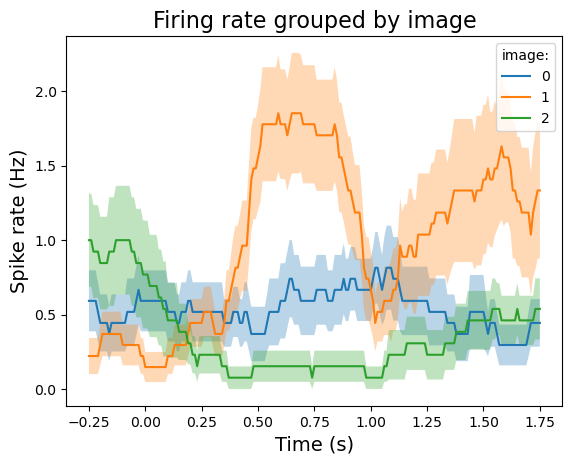

In [39]:
ax = pln.plot_spike_rate(frate.sel(cell=sel_names[0]), groupby='image')

Compare to spike density:

In [42]:
fdens = spk_epochs.spike_density(
    winlen=0.5, picks=sel_names)

<Axes: title={'center': 'Firing rate grouped by image'}, xlabel='Time (s)', ylabel='Spike rate (Hz)'>

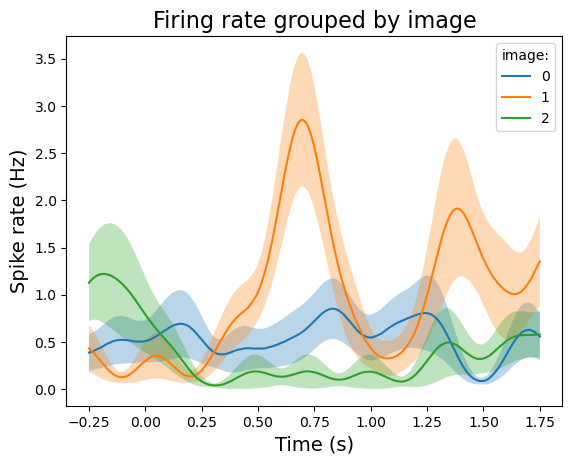

In [43]:
pln.plot_spike_rate(fdens.isel(cell=0), groupby='image')

Before we proceed let's take another look at xarray plotting with `.groupby()` method.
We will compare 

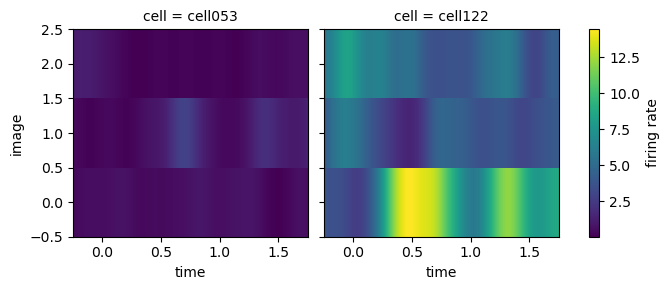

In [47]:
fdens.groupby('image').mean(dim='trial').plot(col='cell')

We see that the second cell has nicer selectivity, let's take a look at its responses trial by trial.

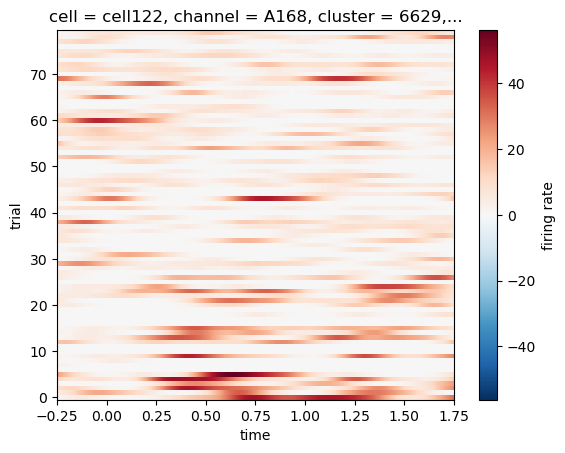

In [72]:
# we select the second cell and sort trials by image id
fdens_srt = fdens.isel(cell=1).sortby('image')

# we re-index trials to avoid xarray plotting error
fdens_srt.coords['trial'] = np.sort(fdens_srt.trial.values)

# plot the spike density trial-by-trial with trials sorted by image id
fdens_srt.plot(y='trial')

We see that the cell does not respond every time when its preferred image was presented (bottom 25 trials). We should see the same information in the rasterplot:

<Axes: xlabel='Time (s)', ylabel='Trial'>

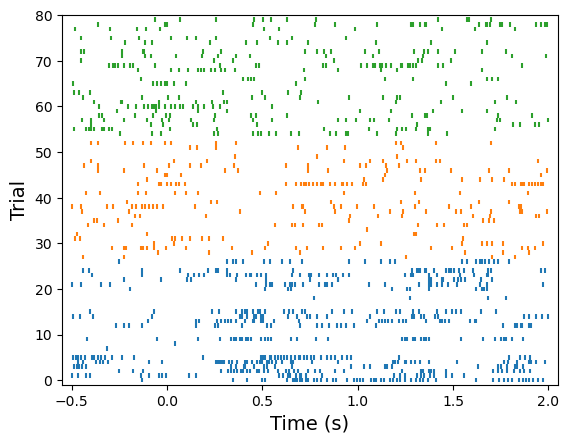

In [74]:
pln.viz.plot_raster(spk_epochs, pick=sel_names[1], groupby='image')

Indeed.  
  
Let's take a look at the average responses grouped by image id:

<Axes: title={'center': 'Firing rate grouped by image'}, xlabel='Time (s)', ylabel='Spike rate (Hz)'>

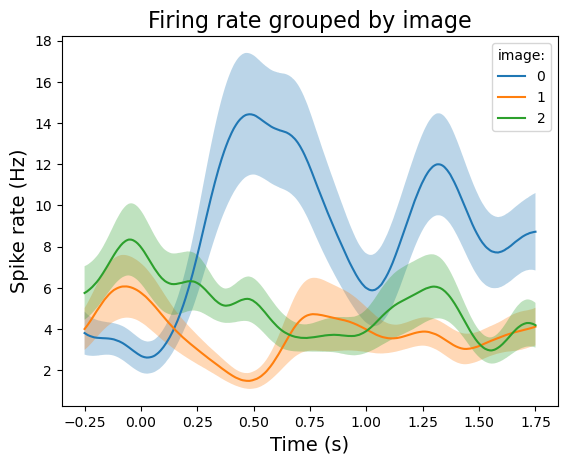

In [86]:
pln.plot_spike_rate(fdens.isel(cell=1), groupby='image')

Finally let's calculate omega-squared percentage explained variance for this cell:

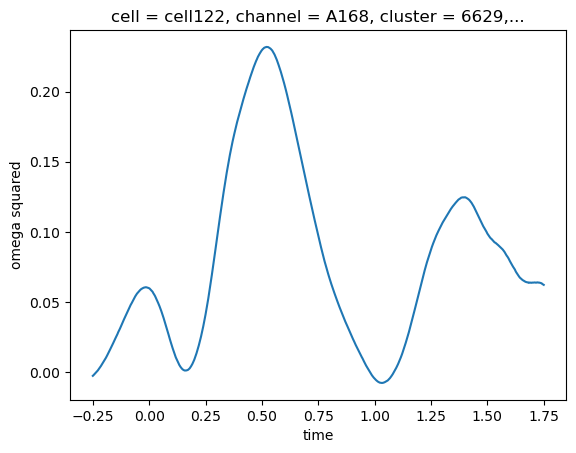

In [75]:
pev = pln.selectivity.explained_variance(
    fdens.isel(cell=1), groupby='image')
pev.plot()

Image identity exaplains above 20% of spiking rate variability around 500 ms after image onset. We can also see average explained variance in the cluster selectivity window:

In [77]:
df_cluster_sel.iloc[1][['neuron', 'window', 'DoS', 'FR_preferred']]

neuron                cell122
window          0.250 - 0.890
DoS                   0.70045
FR_preferred        12.847222
Name: 14, dtype: object

In [80]:
# we'll shrink the window by 100 ms on each side, because it was obtained from
# spike rate, and now we're using spike density (don't do this at home! ;) )
time_window = slice(0.250 + 0.1, 0.890 - 0.1)

max_pev = pev.max().item()
mean_pev = pev.sel(time=time_window).mean(dim='time').item()

print(f'Peak explained variance: {max_pev * 100:.1f} %\n'
      f'Average explained variance in selectivity window: {mean_pev * 100:.1f} %')

Peak explained variance: 23.2 %
Average explained variance in selectivity window: 17.7 %


Let's end this overview with a nice plot :)

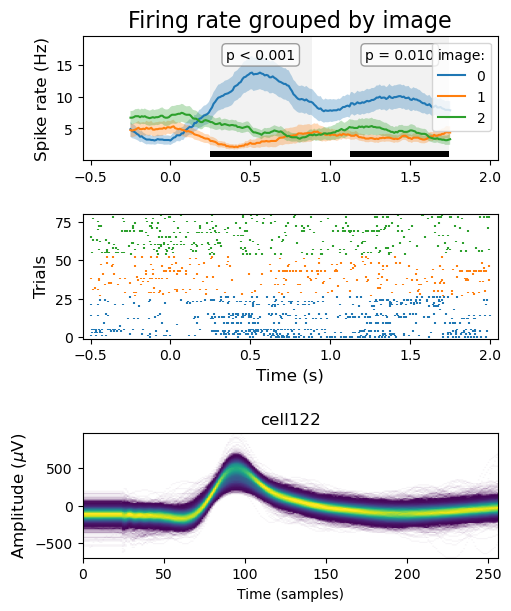

In [88]:
import matplotlib.pyplot as plt

cell_name = 'cell122'
gridspec_kw = {'bottom': 0.15, 'left': 0.15, 'top': 0.95, 'hspace': 0.15}
fig, ax = plt.subplots(nrows=3, figsize=(5, 6), gridspec_kw=gridspec_kw)

pln.viz.plot_spikes(spk_epochs, frate, groupby='image', pick=cell_name,
                    df_clst=df_cluster, ax=ax[:2])

pln.viz.plot_waveform(spk, picks=cell_name, ax=ax[-1])
ax[-1].yaxis.label.set_fontsize(12)
fig.set_constrained_layout(True)